# Random Forest Regression Predictions

In [2]:
import carto
import requests
from sklearn.cluster import KMeans
import geopandas as gpd
import pandas as pd
import rtree
import pygris as pg
import matplotlib.pyplot as plt
import pyproj

## Training/Testing Data

Below are performed the same 311, L&I, and census API pulls for 2020 only.

In [3]:
##311 training/testing data

#connect to 311 API
url = '''https://phl.carto.com/api/v2/sql?q=SELECT *
        FROM public_cases_fc
        WHERE subject = 'Illegal Dumping' AND requested_datetime >= '2020-01-01' AND requested_datetime <= '2020-12-31'
        '''

response = requests.get(url)

data = response.json()

#convert to dataframe
df = pd.DataFrame.from_dict(data['rows'])

#convert to geodataframe
dump_train = gpd.GeoDataFrame(df, geometry= gpd.points_from_xy(df['lon'], df['lat']),crs="EPSG:4326")
dump_train.to_crs("EPSG:2272")
dump_train.head()

C:\Users\tup48123\Anaconda3\envs\geospatialProject\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


,cartodb_id,the_geom,the_geom_webmercator,objectid,service_request_id,subject,status,status_notes,service_name,service_code,...,requested_datetime,updated_datetime,expected_datetime,closed_datetime,address,zipcode,media_url,lat,lon,geometry
0,1413,0101000020E610000047A87C7CC0CE52C0A0F74A49A4FC...,0101000020110F0000A021C03157F25FC189DA649A2C8C...,21984146,13296909,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2020-04-15T16:23:54Z,2022-03-12T06:29:14Z,2020-04-22T20:00:00Z,2020-04-16T15:31:57Z,5430 MASTER ST,19131,None,39.973764,-75.230498,POINT (-75.23050 39.97376)
1,1420,0101000020E61000004D97CD356FC952C0803906A6CB01...,0101000020110F0000E5DE0CEE4EE95FC124A9063AE391...,21824681,13117309,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2020-01-30T09:48:41Z,2022-03-12T06:30:22Z,2020-02-05T19:00:00Z,2020-01-31T07:46:10Z,1200 W LUZERNE ST,19140,None,40.014027,-75.147413,POINT (-75.14741 40.01403)
2,1581,0101000020E61000007243213C39C652C0FF942A51F6FF...,0101000020110F0000809DDEB8DAE35FC1BA62A7D5DA8F...,22152510,13491800,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2020-07-15T08:36:54Z,2022-03-12T06:27:14Z,2020-07-21T20:00:00Z,2020-08-10T09:34:16Z,3716 CORAL ST,19124,None,39.999704,-75.097243,POINT (-75.09724 39.99970)
3,1601,0101000020E6100000EFD7114590C952C06CA201825A00...,0101000020110F000081A0C21587E95FC1F28798EA4990...,21824657,13117451,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2020-01-30T10:17:24Z,2022-03-12T06:30:22Z,2020-02-05T19:00:00Z,2020-02-11T13:02:16Z,1216 W WESTMORELAND ST,19140,None,40.002762,-75.149431,POINT (-75.14943 40.00276)
4,1603,0101000020E61000004123BF1B9EC952C08B1834FC4001...,0101000020110F000075805A979EE95FC1579B55774991...,21984124,13297246,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2020-04-15T19:08:15Z,2022-03-12T08:37:21Z,2020-04-22T20:00:00Z,2020-04-21T07:31:02Z,3700 N WATTS ST,19140,None,40.009796,-75.150275,POINT (-75.15028 40.00980)


In [4]:
#L&I data training and testing
url = '''https://phl.carto.com/api/v2/sql?q=SELECT *
        FROM permits
        WHERE permitissuedate >= '2020-01-01' AND permitissuedate <= '2020-12-31'
        AND typeofwork = 'NEW CONSTRUCTION' OR applicanttype = 'CONTRACTOR'
        '''

response = requests.get(url)

data = response.json()

#convert to df
df = pd.DataFrame.from_dict(data['rows'])

#convert to gdf
lni_train = gpd.GeoDataFrame(df, geometry= gpd.points_from_xy(df['geocode_x'], df['geocode_y']),crs="ESRI:102729")
lni_train.to_crs("EPSG:2272")
lni_train.head()

C:\Users\tup48123\Anaconda3\envs\geospatialProject\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


,cartodb_id,the_geom,the_geom_webmercator,objectid,permitnumber,addressobjectid,parcel_id_num,permittype,permitdescription,commercialorresidential,...,unit_num,zip,censustract,council_district,opa_owner,systemofrecord,geocode_x,geocode_y,posse_jobid,geometry
0,4,0101000020E61000003A1454D3B4CB52C0B0D874103505...,0101000020110F0000939EAFDC2AED5FC190EEB6F4AB95...,18,1003639,421384,117265,PP_PLUMBNG,PLUMBING PERMIT,None,...,None,19144-2606,238,8,TALIAFERRO MELVIN LINWOOD,HANSEN,2.687164e+06,268123.238730,None,POINT (2687164.163 268123.239)
1,5,0101000020E61000009CAFC625C7CC52C09A4AB58C08FA...,0101000020110F0000EACA5FD3FCEE5FC1A42B82B04889...,19,1003773,762208,492953,BP_DEMO,DEMOLITION PERMIT,None,...,None,19104-3605,88.01,3,TRUSTEES OF THE UNIVERSIT,HANSEN,2.683396e+06,236200.284990,None,POINT (2683396.372 236200.285)
2,7,0101000020E610000025522E0FC0CB52C0B4893B6E5FF7...,0101000020110F000048639CF13DED5FC111088E2C5686...,21,1004127,565450,357397,PP_PLUMBNG,PLUMBING PERMIT,None,...,None,19145-1330,32,2,WILLIAMS THELMA,HANSEN,2.688116e+06,228761.877700,None,POINT (2688116.300 228761.878)
3,9,0101000020E61000008974788A13CA52C0E410E947FCFC...,0101000020110F00007A4CEA0F66EA5FC1E7212B208E8C...,23,1004842,50269,363989,EP_ELECTRL,ELECTRICAL PERMIT,None,...,None,19122-3328,146,5,ZION INVEST CORP,HANSEN,2.694979e+06,244942.680172,None,POINT (2694979.081 244942.680)
4,10,0101000020E6100000CA7229D735CD52C00A716818CEFB...,0101000020110F00008D8746D9B8EF5FC1F27C5D3C3F8B...,24,1005186,53967,167407,PP_PLUMBNG,PLUMBING PERMIT,None,...,None,19104-4816,107,3,4115BROWN LLC,HANSEN,2.681358e+06,241185.645082,None,POINT (2681357.849 241185.645)


In [5]:
#census training and testing
#the previous census pull from census_api.ipynb was for 2020 so we can use the same 
census_train = gpd.read_file('output/census_data.gpkg', crs="EPSG:2272")
census_train.to_crs("EPSG:2272")
census_train.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME_x', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'NAME',
       'tot_pop', 'hispLat_pop', 'white_pop', 'black_pop', 'asian_pop',
       'state', 'county', 'tract', 'poc_pop', 'med_inc', 'under_50k',
       'lang_sp', 'lang_other', 'hispLat_pop_pct', 'white_pop_pct',
       'black_pop_pct', 'asian_pop_pct', 'poc_pop_pct', 'under_50k_pct',
       'lang_sp_pct', 'lang_other_pct', 'geometry'],
      dtype='object')

###### Merge training/testing data

In [6]:
#load geography
tracts = gpd.read_file('output/tracts.gpkg')
tracts.to_crs("EPSG:2272")

#crs
orig_crs = pyproj.CRS('EPSG:4326')

# Define the target CRS
target_crs = pyproj.CRS('EPSG:2272')

# Transform the geometry column to the target CRS
dump_train['geometry'] = dump_train['geometry'].to_crs(target_crs)

#aggregate points
agg_311 = gpd.sjoin(dump_train, tracts, how="inner", op='within')
agg_lni = gpd.sjoin(lni_train, tracts, how="inner", op='within')

#group
geoid_311 = agg_311.groupby("GEOID")['objectid'].count().rename('cnt_dump')
geoid_lni = agg_lni.groupby("GEOID")['typeofwork'].count().rename('cnt_construct')

geoid_311

C:\Users\tup48123\AppData\Local\Temp\ipykernel_2652\41766680.py:15: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:2272

  agg_311 = gpd.sjoin(dump_train, tracts, how="inner", op='within')


GEOID
42101000101    110
42101000102     44
42101000200    286
42101000300     52
42101000401     10
              ... 
42101980903      8
42101980904      4
42101980906     16
42101989100      2
42101989300     38
Name: cnt_dump, Length: 399, dtype: int64

###### Perform a spatial join for 311 and L&I point data with census tracts

<AxesSubplot: >

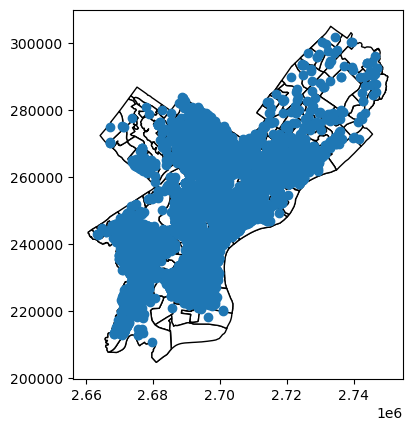

In [7]:
#change CRS to match
dump_train.to_crs("EPSG:2272")
tracts.to_crs("EPSG:2272")
dump_train.crs

ax= tracts.plot(color='white', edgecolor = 'black')
dump_train.head(10000).plot(ax=ax)

In [18]:
#merge to tracts
tracts_train = tracts.merge(geoid_311, on="GEOID").merge(geoid_lni, on="GEOID").merge(census_train[['GEOID','tot_pop', 'hispLat_pop',
        'white_pop', 'black_pop', 'asian_pop', 'poc_pop', 'med_inc', 'under_50k', 'lang_sp', 'lang_other', 'hispLat_pop_pct',
        'white_pop_pct', 'black_pop_pct', 'asian_pop_pct', 'poc_pop_pct', 'under_50k_pct', 'lang_sp_pct', 'lang_other_pct']],
        on="GEOID")
tracts_train

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,white_pop_pct,black_pop_pct,asian_pop_pct,poc_pop_pct,under_50k_pct,lang_sp_pct,lang_other_pct,state,county,tract
0,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,...,0.024447,0.879705,0.004657,0.975553,0.891347,0.000000,0.000000,42,101,039100
1,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,...,0.024447,0.879705,0.004657,0.975553,0.891347,0.000000,0.000000,42,101,039100
2,42,101,980904,42101980904,9809.04,Census Tract 9809.04,G5020,S,1570844,158459,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,42,101,980904
3,42,101,980903,42101980903,9809.03,Census Tract 9809.03,G5020,S,171154,0,...,0.000000,0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,42,101,980903
4,42,101,980903,42101980903,9809.03,Census Tract 9809.03,G5020,S,171154,0,...,0.000000,0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,42,101,980903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,42,101,000902,42101000902,9.02,Census Tract 9.02,G5020,S,155167,0,...,0.641098,0.051372,0.235046,0.358902,0.554187,0.002815,0.121042,42,101,000902
693,42,101,001201,42101001201,12.01,Census Tract 12.01,G5020,S,327555,30728,...,0.795092,0.019226,0.072856,0.204908,0.294713,0.030357,0.018973,42,101,001201
694,42,101,001201,42101001201,12.01,Census Tract 12.01,G5020,S,327555,30728,...,0.795092,0.019226,0.072856,0.204908,0.294713,0.030357,0.018973,42,101,001201
695,42,101,002702,42101002702,27.02,Census Tract 27.02,G5020,S,367675,0,...,0.819353,0.027882,0.049438,0.180647,0.486410,0.019681,0.013590,42,101,002702


In [19]:
tracts_train.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'count',
       'status', 'geometry', 'cnt_dump', 'cnt_construct', 'tot_pop',
       'hispLat_pop', 'white_pop', 'black_pop', 'asian_pop', 'poc_pop',
       'med_inc', 'under_50k', 'lang_sp', 'lang_other', 'hispLat_pop_pct',
       'white_pop_pct', 'black_pop_pct', 'asian_pop_pct', 'poc_pop_pct',
       'under_50k_pct', 'lang_sp_pct', 'lang_other_pct', 'state', 'county',
       'tract'],
      dtype='object')

In [22]:
#normalize L&I and 311 data
tracts_train['cnt_const_pct'] = tracts_train['cnt_construct']/tracts_train['tot_pop']
tracts_train['dump_pct'] = tracts_train['cnt_dump']/tracts_train['tot_pop']
tracts_train['pop_den'] = tracts_train['tot_pop']/(tracts_train['ALAND']/1000000) #ALAND is land area in m^2

tracts_train

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,poc_pop_pct,under_50k_pct,lang_sp_pct,lang_other_pct,state,county,tract,cnt_const_pct,dump_pct,pop_den
0,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,...,0.975553,0.891347,0.000000,0.000000,42,101,039100,0.174622,0.062864,2301.305859
1,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,...,0.975553,0.891347,0.000000,0.000000,42,101,039100,0.174622,0.062864,2301.305859
2,42,101,980904,42101980904,9809.04,Census Tract 9809.04,G5020,S,1570844,158459,...,1.000000,0.000000,0.000000,0.000000,42,101,980904,21.000000,4.000000,0.636600
3,42,101,980903,42101980903,9809.03,Census Tract 9809.03,G5020,S,171154,0,...,1.000000,0.000000,0.000000,0.000000,42,101,980903,16.333333,1.333333,35.056148
4,42,101,980903,42101980903,9809.03,Census Tract 9809.03,G5020,S,171154,0,...,1.000000,0.000000,0.000000,0.000000,42,101,980903,16.333333,1.333333,35.056148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,42,101,000902,42101000902,9.02,Census Tract 9.02,G5020,S,155167,0,...,0.358902,0.554187,0.002815,0.121042,42,101,000902,1.144968,0.028149,18315.750127
693,42,101,001201,42101001201,12.01,Census Tract 12.01,G5020,S,327555,30728,...,0.204908,0.294713,0.030357,0.018973,42,101,001201,0.965849,0.027827,12068.202287
694,42,101,001201,42101001201,12.01,Census Tract 12.01,G5020,S,327555,30728,...,0.204908,0.294713,0.030357,0.018973,42,101,001201,0.965849,0.027827,12068.202287
695,42,101,002702,42101002702,27.02,Census Tract 27.02,G5020,S,367675,0,...,0.180647,0.486410,0.019681,0.013590,42,101,002702,0.991565,0.026242,11608.077786


## New data

New pulls are performed from the three APIs for the same data, but filtered by 01/01/2021 to present.

In [9]:
##311 new data

#connect to 311 API
url = '''https://phl.carto.com/api/v2/sql?q=SELECT *
        FROM public_cases_fc
        WHERE subject = 'Illegal Dumping' AND requested_datetime > '2020-12-31'
        '''

response = requests.get(url)

data = response.json()

#convert to dataframe
df = pd.DataFrame.from_dict(data['rows'])

#convert to geodataframe
dump_new = gpd.GeoDataFrame(df, geometry= gpd.points_from_xy(df['lon'], df['lat']),crs="EPSG:4326")
dump_new.to_crs("EPSG:2272")
dump_new.head()

C:\Users\tup48123\Anaconda3\envs\geospatialProject\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


,cartodb_id,the_geom,the_geom_webmercator,objectid,service_request_id,subject,status,status_notes,service_name,service_code,...,requested_datetime,updated_datetime,expected_datetime,closed_datetime,address,zipcode,media_url,lat,lon,geometry
0,27,0101000020E6100000462E933CF2C852C0AAAFF8976E00...,0101000020110F0000BA3255A67AE85FC1840CA92F6090...,23171921,14841749,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2022-04-04T19:30:32Z,2023-02-15T22:11:37Z,2022-04-11T20:00:00Z,2022-04-18T10:23:35Z,3416 N 6TH ST,19140,None,40.003375,-75.139785,POINT (-75.13978 40.00338)
1,66,0101000020E610000085615D6830CE52C016363D079AF7...,0101000020110F0000EC7E5B7662F15FC10AC7BD139786...,23123101,14780011,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2022-03-07T14:13:11Z,2023-02-15T22:01:20Z,2022-03-14T20:00:00Z,2022-07-15T04:48:08Z,2000 S 56TH ST,19143,https://d17aqltn7cihbm.cloudfront.net/uploads/...,39.934388,-75.221705,POINT (-75.22170 39.93439)
2,67,0101000020E6100000D38E552901C852C0B79E5BC73CFE...,0101000020110F00003B40C928E1E65FC11DA7EA5BF18D...,22786271,14360829,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2021-08-20T08:40:51Z,2022-03-12T02:39:54Z,2021-08-26T20:00:00Z,2021-08-24T07:34:44Z,2011 E HUNTINGDON ST,19125,https://d17aqltn7cihbm.cloudfront.net/uploads/...,39.986230,-75.125071,POINT (-75.12507 39.98623)
3,78,0101000020E61000002286C20C32C952C0871DBE337701...,0101000020110F00001F9FFC0AE7E85FC1B051BC958591...,23123103,14780013,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2022-03-07T14:13:26Z,2023-02-15T22:00:29Z,2022-03-14T20:00:00Z,2022-03-28T06:07:47Z,3890 N 10TH ST,19140,https://d17aqltn7cihbm.cloudfront.net/uploads/...,40.011450,-75.143680,POINT (-75.14368 40.01145)
4,217,0101000020E610000045AC51512DC852C0FD97B55E1D04...,0101000020110F0000CDEABD292CE75FC102F1B6B27594...,22844416,14431511,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2021-09-21T05:01:24Z,2023-02-15T22:08:42Z,2021-09-27T20:00:00Z,2021-09-30T10:49:07Z,5325 N 3RD ST,19120,None,40.032146,-75.127766,POINT (-75.12777 40.03215)


In [10]:
#L&I new data 
url = '''https://phl.carto.com/api/v2/sql?q=SELECT *
        FROM permits
        WHERE permitissuedate > '2020-12-31'
        AND typeofwork = 'NEW CONSTRUCTION' OR applicanttype = 'CONTRACTOR'
        '''

response = requests.get(url)

data = response.json()

#convert to df
df = pd.DataFrame.from_dict(data['rows'])

#convert to gdf
lni_new = gpd.GeoDataFrame(df, geometry= gpd.points_from_xy(df['geocode_x'], df['geocode_y']),crs="ESRI:102729")
lni_new.head()

C:\Users\tup48123\Anaconda3\envs\geospatialProject\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


,cartodb_id,the_geom,the_geom_webmercator,objectid,permitnumber,addressobjectid,parcel_id_num,permittype,permitdescription,commercialorresidential,...,unit_num,zip,censustract,council_district,opa_owner,systemofrecord,geocode_x,geocode_y,posse_jobid,geometry
0,4,0101000020E61000003A1454D3B4CB52C0B0D874103505...,0101000020110F0000939EAFDC2AED5FC190EEB6F4AB95...,18,1003639,421384,117265,PP_PLUMBNG,PLUMBING PERMIT,None,...,None,19144-2606,238,8,TALIAFERRO MELVIN LINWOOD,HANSEN,2.687164e+06,268123.238730,None,POINT (2687164.163 268123.239)
1,5,0101000020E61000009CAFC625C7CC52C09A4AB58C08FA...,0101000020110F0000EACA5FD3FCEE5FC1A42B82B04889...,19,1003773,762208,492953,BP_DEMO,DEMOLITION PERMIT,None,...,None,19104-3605,88.01,3,TRUSTEES OF THE UNIVERSIT,HANSEN,2.683396e+06,236200.284990,None,POINT (2683396.372 236200.285)
2,7,0101000020E610000025522E0FC0CB52C0B4893B6E5FF7...,0101000020110F000048639CF13DED5FC111088E2C5686...,21,1004127,565450,357397,PP_PLUMBNG,PLUMBING PERMIT,None,...,None,19145-1330,32,2,WILLIAMS THELMA,HANSEN,2.688116e+06,228761.877700,None,POINT (2688116.300 228761.878)
3,9,0101000020E61000008974788A13CA52C0E410E947FCFC...,0101000020110F00007A4CEA0F66EA5FC1E7212B208E8C...,23,1004842,50269,363989,EP_ELECTRL,ELECTRICAL PERMIT,None,...,None,19122-3328,146,5,ZION INVEST CORP,HANSEN,2.694979e+06,244942.680172,None,POINT (2694979.081 244942.680)
4,10,0101000020E6100000CA7229D735CD52C00A716818CEFB...,0101000020110F00008D8746D9B8EF5FC1F27C5D3C3F8B...,24,1005186,53967,167407,PP_PLUMBNG,PLUMBING PERMIT,None,...,None,19104-4816,107,3,4115BROWN LLC,HANSEN,2.681358e+06,241185.645082,None,POINT (2681357.849 241185.645)


In [11]:
#get census new data
HOST = "https://api.census.gov/data"

year = "2021"

dataset = "acs/acs5"

base_url = "/".join([HOST, year, dataset])

predicates = {}

varLst = ["NAME", "B01003_001E", "B03001_003E", "B01001H_001E", "B01001B_001E", "B01001D_001E",
          "B06011_001E", "B07010_002E", "B07010_004E", "B07010_005E", "B07010_006E", "B07010_007E",
          "B07010_008E", "B06007_005E", "B06007_008E"]

predicates["get"] = ",".join(varLst)

predicates["for"] = "tract:*"

predicates["in"] = "state: 42 & county: 101"

census_new = requests.get(base_url, params=predicates)

#convert to dataframe
census_new = census_new.json()
census_new = pd.DataFrame(census_new[1:], columns=census_new[0])
col_names = ["tot_pop", "hispLat_pop", "white_pop", "black_pop", "asian_pop", "med_inc", "no_inc", "under_10k", "under15k", "under25k", "under35k", "under50k", "lang_sp", "lang_other"]
#df_r

#rename columns
for i in range(len(col_names)):
    census_new= census_new.rename(columns={census_new.columns[i+1]: col_names[i]})

#change datatype to integers
for i in census_new.columns:
    if i in col_names:
        census_new[i] = census_new[i].apply(lambda x: int(x))


#calculate new column
census_new['poc_pop'] = census_new['tot_pop'] - census_new['white_pop']
census_new['under_50k'] = census_new['no_inc'] + census_new['under_10k'] +census_new['under15k'] + census_new['under25k'] +census_new['under35k'] +census_new['under50k']

census_new   

,NAME,tot_pop,hispLat_pop,white_pop,black_pop,asian_pop,med_inc,no_inc,under_10k,under15k,under25k,under35k,under50k,lang_sp,lang_other,state,county,tract,poc_pop,under_50k
0,"Census Tract 1.01, Philadelphia County, Pennsy...",2004,346,1453,28,157,90000,0,93,55,61,129,168,13,13,42,101,000101,551,506
1,"Census Tract 1.02, Philadelphia County, Pennsy...",2752,134,2425,82,76,83538,46,86,104,138,115,140,0,19,42,101,000102,327,629
2,"Census Tract 2, Philadelphia County, Pennsylvania",3414,171,972,225,1888,37553,295,448,220,110,551,352,3,664,42,101,000200,2442,1976
3,"Census Tract 3, Philadelphia County, Pennsylvania",3566,267,2068,218,615,66863,164,458,153,142,125,262,3,146,42,101,000300,1498,1304
4,"Census Tract 4.01, Philadelphia County, Pennsy...",2573,87,1538,375,475,55662,101,473,155,187,120,147,0,264,42,101,000401,1035,1183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,"Census Tract 9809.05, Philadelphia County, Pen...",0,0,0,0,0,-666666666,0,0,0,0,0,0,0,0,42,101,980905,0,0
404,"Census Tract 9809.06, Philadelphia County, Pen...",0,0,0,0,0,-666666666,0,0,0,0,0,0,0,0,42,101,980906,0,0
405,"Census Tract 9891, Philadelphia County, Pennsy...",1749,296,180,1272,27,14817,1065,263,82,157,98,15,38,11,42,101,989100,1569,1680
406,"Census Tract 9892, Philadelphia County, Pennsy...",0,0,0,0,0,-666666666,0,0,0,0,0,0,0,0,42,101,989200,0,0


#### Merge new data
###### Aggregate the point data and group by census tract

In [12]:
#crs
orig_crs = pyproj.CRS('EPSG:4326')
target_crs = pyproj.CRS('EPSG:2272')
# Transform the geometry column to the target CRS
dump_new['geometry'] = dump_new['geometry'].to_crs(target_crs)

#aggregate points
agg_311_new = gpd.sjoin(dump_new, tracts, how="inner", op='within')
agg_lni_new = gpd.sjoin(lni_new, tracts, how="inner", op='within')

#group
geoid_311_new = agg_311_new.groupby("GEOID")['objectid'].count().rename('cnt_dump')
geoid_lni_new = agg_lni_new.groupby("GEOID")['typeofwork'].count().rename('cnt_construct')

geoid_311_new

C:\Users\tup48123\AppData\Local\Temp\ipykernel_2652\3250247914.py:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:2272

  agg_311_new = gpd.sjoin(dump_new, tracts, how="inner", op='within')


GEOID
42101000101    324
42101000102    119
42101000200    456
42101000300    400
42101000401     40
              ... 
42101980905      2
42101980906     48
42101989100      4
42101989200      2
42101989300    172
Name: cnt_dump, Length: 405, dtype: int64

Check if CRS match

<AxesSubplot: >

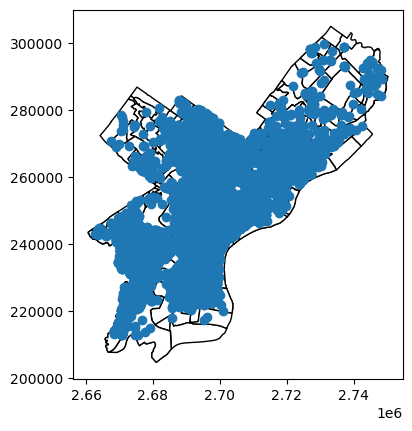

In [13]:
dump_new.to_crs("EPSG:2272")
tracts.to_crs("EPSG:2272")
dump_new.crs

ax= tracts.plot(color='white', edgecolor = 'black')
dump_new.head(10000).plot(ax=ax)

In [14]:
#merge census data to tracts
tracts_new = tracts.merge(census_new[['tot_pop', 'hispLat_pop', 'white_pop', 'black_pop', 'asian_pop','poc_pop','tract',
                                      'med_inc', 'under_50k', 'lang_sp', 'lang_other']], left_on='TRACTCE', right_on='tract')
tracts_new.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'count',
       'status', 'geometry', 'tot_pop', 'hispLat_pop', 'white_pop',
       'black_pop', 'asian_pop', 'poc_pop', 'tract', 'med_inc', 'under_50k',
       'lang_sp', 'lang_other'],
      dtype='object')

In [15]:
#merge 311 data to tracts
tracts_new = tracts_new.merge(geoid_311_new, on="GEOID").merge(geoid_lni_new, on="GEOID")
tracts_new.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'count',
       'status', 'geometry', 'tot_pop', 'hispLat_pop', 'white_pop',
       'black_pop', 'asian_pop', 'poc_pop', 'tract', 'med_inc', 'under_50k',
       'lang_sp', 'lang_other', 'cnt_dump', 'cnt_construct'],
      dtype='object')

In [23]:
#normalize data by population
#normalize L&I and 311 data
tracts_new['cnt_const_pct'] = tracts_new['cnt_construct']/tracts_new['tot_pop']
tracts_new['dump_pct'] = tracts_new['cnt_dump']/tracts_new['tot_pop']
tracts_new['pop_den'] = tracts_new['tot_pop']/(tracts_new['ALAND']/1000000) #ALAND is land area in m^2

cols_names = ["tot_pop", "hispLat_pop", "white_pop", "black_pop", "asian_pop", 'poc_pop', "med_inc", "under_50k", "lang_sp", "lang_other"]


for col in cols_names:
    if col in tracts_new.columns and col!= 'tot_pop' and col != 'med_inc':
        tracts_new[f'{col}_pct']= tracts_new[col]/tracts_new['tot_pop']
        
tracts_new

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,dump_pct,pop_den,hispLat_pop_pct,white_pop_pct,black_pop_pct,asian_pop_pct,poc_pop_pct,under_50k_pct,lang_sp_pct,lang_other_pct
0,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,...,0.107466,3157.709553,0.024038,0.000000,0.972002,0.006505,1.000000,0.633484,0.000000,0.000000
1,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,...,0.107466,3157.709553,0.024038,0.000000,0.972002,0.006505,1.000000,0.633484,0.000000,0.000000
2,42,101,980904,42101980904,9809.04,Census Tract 9809.04,G5020,S,1570844,158459,...,inf,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,42,101,980903,42101980903,9809.03,Census Tract 9809.03,G5020,S,171154,0,...,inf,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,42,101,980903,42101980903,9809.03,Census Tract 9809.03,G5020,S,171154,0,...,inf,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,42,101,000902,42101000902,9.02,Census Tract 9.02,G5020,S,155167,0,...,0.073703,18012.850671,0.043292,0.698032,0.044723,0.185331,0.301968,0.546691,0.002862,0.130948
700,42,101,001201,42101001201,12.01,Census Tract 12.01,G5020,S,327555,30728,...,0.042423,12953.549786,0.069291,0.754890,0.042187,0.057506,0.245110,0.297195,0.025689,0.019326
701,42,101,001201,42101001201,12.01,Census Tract 12.01,G5020,S,327555,30728,...,0.042423,12953.549786,0.069291,0.754890,0.042187,0.057506,0.245110,0.297195,0.025689,0.019326
702,42,101,002702,42101002702,27.02,Census Tract 27.02,G5020,S,367675,0,...,0.064228,12195.553138,0.065789,0.774978,0.065120,0.019179,0.225022,0.480821,0.012489,0.000446


In [24]:
tracts_new.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'count',
       'status', 'geometry', 'tot_pop', 'hispLat_pop', 'white_pop',
       'black_pop', 'asian_pop', 'poc_pop', 'tract', 'med_inc', 'under_50k',
       'lang_sp', 'lang_other', 'cnt_dump', 'cnt_construct', 'cnt_const_pct',
       'dump_pct', 'pop_den', 'hispLat_pop_pct', 'white_pop_pct',
       'black_pop_pct', 'asian_pop_pct', 'poc_pop_pct', 'under_50k_pct',
       'lang_sp_pct', 'lang_other_pct'],
      dtype='object')

## Random Forest

In [26]:
# Compute correlation matrix between all numeric columns
corr_matrix = tracts_train[['cnt_dump','dump_pct', 'tot_pop', 'hispLat_pop', 'white_pop',
       'black_pop', 'asian_pop', 'poc_pop', 'med_inc', 'under_50k',
       'lang_sp', 'lang_other', 'cnt_construct', 'cnt_const_pct',
        'pop_den', 'hispLat_pop_pct', 'white_pop_pct',
       'black_pop_pct', 'asian_pop_pct', 'poc_pop_pct', 'under_50k_pct',
       'lang_sp_pct', 'lang_other_pct']].corr()

# Print correlation matrix
print(corr_matrix)

                 cnt_dump  dump_pct   tot_pop  hispLat_pop  white_pop  \
cnt_dump         1.000000 -0.027884  0.193333     0.260298  -0.192756   
dump_pct        -0.027884  1.000000 -0.212735    -0.059538  -0.096081   
tot_pop          0.193333 -0.212735  1.000000     0.454197   0.387545   
hispLat_pop      0.260298 -0.059538  0.454197     1.000000  -0.061017   
white_pop       -0.192756 -0.096081  0.387545    -0.061017   1.000000   
black_pop        0.263253 -0.091421  0.356244    -0.078500  -0.545021   
asian_pop       -0.078922 -0.072765  0.468351     0.174863   0.374587   
poc_pop          0.342435 -0.137379  0.702883     0.502148  -0.383318   
med_inc          0.144514 -0.490598  0.408717     0.128300   0.188968   
under_50k        0.229827 -0.177441  0.889917     0.510223   0.076054   
lang_sp          0.241898 -0.041464  0.321184     0.912874  -0.140210   
lang_other      -0.126071 -0.061175  0.480659     0.202969   0.321717   
cnt_construct    0.362098 -0.040624  0.165280    -0

###### Use regression analysis for the Random Forest predictions using the response variable is continuous
The training/testing dataset is split into training data, using 70% of the data, and testing data using 30.

The accuracy of the model using raw count data is high. Using all variables ('hispLat_pop', 'white_pop','black_pop', 'asian_pop', 'poc_pop', 'med_inc', 'under_50k','lang_sp', 'lang_other', 'cnt_construct'), the accuracy is 79%. Using only variables with a correlation above 0.2 or -0.2, the accuracy is 80%.

From what I can tell from what I read online, Random Forest can accept count data, so I will run two analyses, one with raw counts and one with percentage data.

In [39]:
#random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define independent and dependent variables
X = tracts_train[['hispLat_pop', 'white_pop','black_pop', 'asian_pop', 'poc_pop', 'med_inc',
                  'under_50k','lang_sp', 'lang_other', 'cnt_construct', 'pop_den']]  # independent variables
y = tracts_train['cnt_dump']  # dependent variable

# Split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Test model accuracy
accuracy = rf.score(X_test, y_test)
accuracy

0.8018179461426053

In [40]:
#predict on new data
predict= rf.predict(tracts_new[['hispLat_pop', 'white_pop','black_pop', 'asian_pop', 'poc_pop', 'med_inc', 'under_50k',
       'lang_sp', 'lang_other', 'cnt_construct', 'pop_den']])
predict

array([109.27, 109.27,  15.5 ,  12.18,  12.18,  13.77,  13.77,  15.5 ,
       119.04, 119.04,   7.73,  50.78,  50.78,  32.22,  47.51,   7.24,
        10.93,  25.58,  55.52,  55.52,  46.91,  46.91,  66.  ,  66.  ,
        12.37,  19.68,  19.68,  65.03,  89.44,  89.44, 251.11, 251.11,
       213.5 , 213.5 , 263.34, 263.34, 227.74, 227.74, 136.42, 136.42,
       103.22, 103.22, 141.62, 141.62, 220.36, 220.36,  79.41,  79.41,
       178.46, 178.46,  91.41,  91.41, 183.07, 183.07, 261.42, 261.42,
       173.72, 173.72, 125.86, 125.86, 480.96, 480.96, 321.66, 321.66,
       391.12, 391.12,  78.86,  78.86,  91.93,  91.93, 176.14, 176.14,
       284.3 , 284.3 , 300.24, 300.24, 143.96, 143.96, 320.86, 320.86,
       168.6 , 168.6 , 111.35, 111.35, 225.52, 225.52, 138.18, 138.18,
       274.92, 274.92, 304.  , 304.  ,  72.5 ,  23.97,  55.1 , 246.12,
       246.12, 270.82, 270.82, 198.92, 198.92, 282.16, 282.16,  64.7 ,
        64.7 ,  99.5 ,  99.5 , 393.04, 393.04, 327.34, 327.34, 127.5 ,
      

In [41]:
#add predictions to new data
for i in range(len(tracts_new)):
    tracts_new.loc[i, "preds"] = predict[i]
tracts_new

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,pop_den,hispLat_pop_pct,white_pop_pct,black_pop_pct,asian_pop_pct,poc_pop_pct,under_50k_pct,lang_sp_pct,lang_other_pct,preds
0,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,...,3157.709553,0.024038,0.000000,0.972002,0.006505,1.000000,0.633484,0.000000,0.000000,109.27
1,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,...,3157.709553,0.024038,0.000000,0.972002,0.006505,1.000000,0.633484,0.000000,0.000000,109.27
2,42,101,980904,42101980904,9809.04,Census Tract 9809.04,G5020,S,1570844,158459,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.50
3,42,101,980903,42101980903,9809.03,Census Tract 9809.03,G5020,S,171154,0,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.18
4,42,101,980903,42101980903,9809.03,Census Tract 9809.03,G5020,S,171154,0,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,42,101,000902,42101000902,9.02,Census Tract 9.02,G5020,S,155167,0,...,18012.850671,0.043292,0.698032,0.044723,0.185331,0.301968,0.546691,0.002862,0.130948,68.68
700,42,101,001201,42101001201,12.01,Census Tract 12.01,G5020,S,327555,30728,...,12953.549786,0.069291,0.754890,0.042187,0.057506,0.245110,0.297195,0.025689,0.019326,85.86
701,42,101,001201,42101001201,12.01,Census Tract 12.01,G5020,S,327555,30728,...,12953.549786,0.069291,0.754890,0.042187,0.057506,0.245110,0.297195,0.025689,0.019326,85.86
702,42,101,002702,42101002702,27.02,Census Tract 27.02,G5020,S,367675,0,...,12195.553138,0.065789,0.774978,0.065120,0.019179,0.225022,0.480821,0.012489,0.000446,213.28


Kensington and South Philly are accurately predicted as having high counts of illegal dumping. The tracts with higher predictions overlap with areas with a lot of construction and higher populations of People of Color, especially Latine-majority neighborhoods.

Interestingly, two tracts in the lower Northeast have the highest predictions of dumpings when population density is not included. Once population density is included, those tracts have lower predictions and a new tract in University City appears to have a high prediction. This makes sense since the tracts in question in the lower Northeast have less population than the one in University City.

<AxesSubplot: >

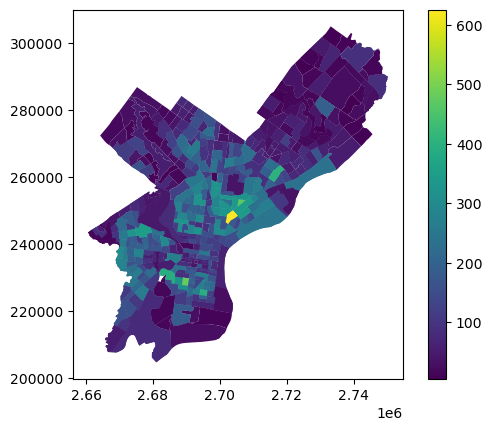

In [42]:
#plot
tracts_new.plot(column='preds', legend=True)

<AxesSubplot: >

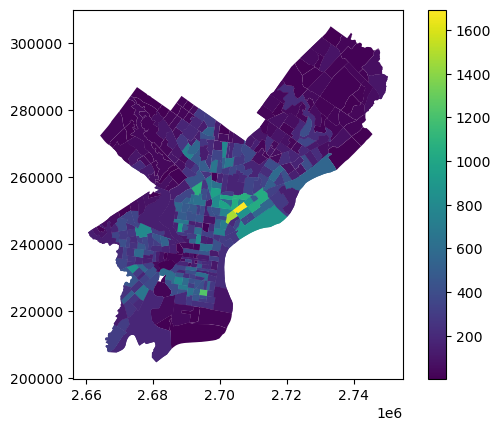

In [61]:
tracts_new.plot(column='cnt_dump', legend=True)

##### Random Forest using normalized data
The correlations using normalized data are mostly insignificant in comparison to those for raw count data. Using only normalized data, the random forest prediction is quite low at 12%.

In [38]:
#random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

#remove NAs
df_train = tracts_train.dropna()

# Define independent and dependent variables
X = df_train[['cnt_const_pct','pop_den', 'hispLat_pop_pct', 'white_pop_pct','black_pop_pct', 'asian_pop_pct',
                  'poc_pop_pct', 'under_50k_pct', 'lang_sp_pct', 'lang_other_pct']]  # independent variables
y = df_train['dump_pct']  # dependent variable

# Split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
rf_train = RandomForestRegressor(n_estimators=100, random_state=42)
rf_train.fit(X_train, y_train)

# Test model accuracy
accuracy = rf_train.score(X_test, y_test)
accuracy

0.12656380001556666

In [32]:
#predict on new data

#remove NAs
df_new = tracts_new.dropna()

predict_new= rf_train.predict(df_new[['cnt_const_pct','pop_den', 'hispLat_pop_pct', 'white_pop_pct','black_pop_pct',
                                      'asian_pop_pct', 'poc_pop_pct', 'under_50k_pct', 'lang_sp_pct', 'lang_other_pct']])
predict

array([3.03304895, 3.03304895, 2.5104188 , 2.5104188 , 2.5104188 ,
       2.5104188 , 2.5104188 , 2.5104188 , 1.15242581, 1.15242581,
       0.68179991, 0.68117787, 0.68117787, 0.7510994 , 0.68456435,
       1.15089767, 0.68117787, 2.5104188 , 0.68165185, 0.68165185,
       0.63972703, 0.63972703, 0.68115777, 0.68115777, 0.68450362,
       0.68456435, 0.68456435, 1.3153464 , 0.75810089, 0.75810089,
       0.85992964, 0.85992964, 0.75810089, 0.75810089, 0.75810089,
       0.75810089, 0.76129386, 0.76129386, 1.15325535, 1.15325535,
       0.68620112, 0.68620112, 1.16981869, 1.16981869, 1.18702592,
       1.18702592, 0.68456435, 0.68456435, 0.68456435, 0.68456435,
       1.17423903, 1.17423903, 0.69460247, 0.69460247, 0.68085708,
       0.68085708, 0.68456435, 0.68456435, 0.68055279, 0.68055279,
       0.69337079, 0.69337079, 0.70726774, 0.70726774, 0.68226132,
       0.68226132, 0.68456435, 0.68456435, 0.68456435, 0.68456435,
       0.69460247, 0.69460247, 1.32879993, 1.32879993, 1.32879

In [33]:
#add predictions to new data
for i in range(len(df_new)):
    df_new.loc[i, "preds"] = predict[i]
df_new

C:\Users\tup48123\Anaconda3\envs\geospatialProject\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\tup48123\AppData\Local\Temp\ipykernel_2652\3757846513.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.loc[i, "preds"] = predict[i]


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,pop_den,hispLat_pop_pct,white_pop_pct,black_pop_pct,asian_pop_pct,poc_pop_pct,under_50k_pct,lang_sp_pct,lang_other_pct,preds
0,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799.0,133239.0,...,3157.709553,0.024038,0.000000,0.972002,0.006505,1.000000,0.633484,0.000000,0.000000,3.033049
1,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799.0,133239.0,...,3157.709553,0.024038,0.000000,0.972002,0.006505,1.000000,0.633484,0.000000,0.000000,3.033049
8,42,101,036700,42101036700,367,Census Tract 367,G5020,S,729908.0,0.0,...,4664.971476,0.057269,0.745668,0.071659,0.098972,0.254332,0.278414,0.000000,0.012628,1.152426
9,42,101,036700,42101036700,367,Census Tract 367,G5020,S,729908.0,0.0,...,4664.971476,0.057269,0.745668,0.071659,0.098972,0.254332,0.278414,0.000000,0.012628,1.152426
10,42,101,034702,42101034702,347.02,Census Tract 347.02,G5020,S,1032346.0,0.0,...,3439.738227,0.084483,0.766826,0.084202,0.063362,0.233174,0.465221,0.039144,0.048719,0.681800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.510419
642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.510419
647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.510419
678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.510419


As expected from the low accuracy rate, the predictions map for normalized data is confusing. It makes sense that the areas in and near Fairmount Park have a higher ratio of dumpings per capita since these tracts have a small population.

<AxesSubplot: >

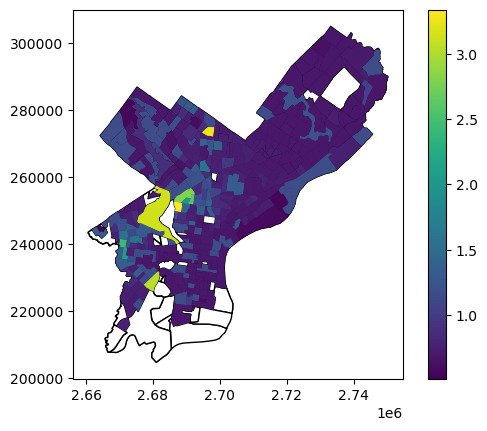

In [44]:
#plot
ax=tracts.plot(color='white', edgecolor='black')
df_new.plot(ax=ax, column='preds', legend=True)

The plot showing actual data for dumpings per capita is hard to read since Fairmount Park is an outlier that makes it hard to see the distribution of the rest of the data. Because of this, I removed the Fairmount Park polygon in the next plot.

<AxesSubplot: >

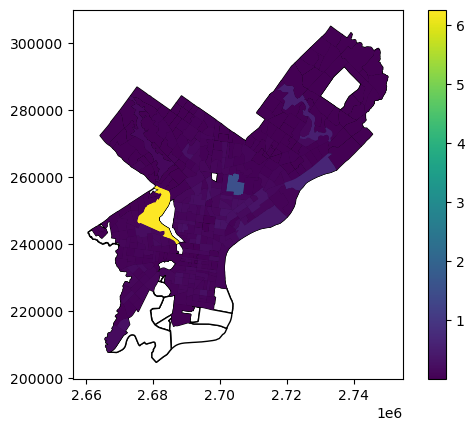

In [46]:
#plot original dumpings per capita
ax=tracts.plot(color='white', edgecolor='black')
df_new.plot(ax=ax, column='dump_pct', legend=True)

Without Fairmount Park, we can see the distribution a bit better. The higher rates per capita are in North Philly, east of Broad Street.

Some more tracts likely need to be removed because they skew the data. The yellow tracts in North Philly likely include Logan Triangle, a vacated residential area with an unfixed sinkhole. Pennypack Park in the Northeast might also need to be removed because it has a smaller population. I would not remove Logan Triangle, however, because vacant lots in or near residential areas were stated as significant in my preliminary research.

<AxesSubplot: >

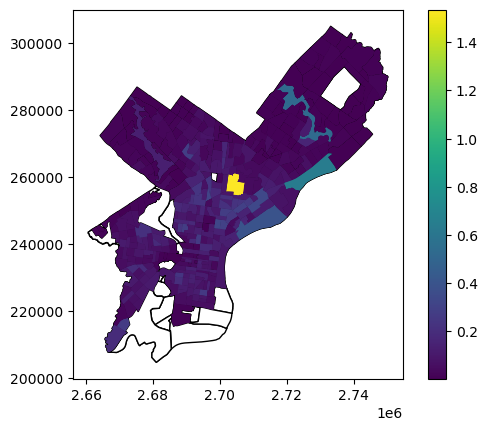

In [56]:
#remove Fairmount Park because it skews the data

df = df_new[df_new['TRACTCE'] != '980002']
#df_new['TRACTCE'].unique()
ax=tracts.plot(color='white', edgecolor='black')
df.plot(ax=ax, column='dump_pct', legend=True)

#### Conclusion
The Random Forest using normalized data performs terribly when compared to the one using raw count data. It seems that a significant presence of indicators can predict where illegal dumpings will take place, but the concentration per capita (except for population density) has no relation.